In [1]:
import argparse
import shutil
import h5py
import numpy as np
import pandas as pd
import cooler
import cooltools
import cooltools.lib.plotting
from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import json
import pickle
from tqdm import tqdm
import os, subprocess
import bioframe
import pyBigWig
import warnings
from sklearn.decomposition import PCA
import sys

In [ ]:
####### parser code for files and parameters (would load data from here) #######

def parse_arg():
    p = argparse.ArgumentParser()
    p.add_argument('-i', help="1D genomic measurements of nuclear organization.")
    p.add_argument('--hic', help="Hi-C interactions.")
    p.add_argument('-w', help="Resolution.", type=int, default=100000)
    p.add_argument('-n', help="Number of states.", type=int, default=5)
    #p.add_argument('-m', help="Choose mode. Supported: full, hic", type=string, default="full")
    p.add_argument('-o', help="Output dir.")
    p.add_argument('-p', help="Number of processes.", type=int)
    p.add_argument('-g', help="Genome bin file.")
    p.add_argument("--prev", help="reload existing model.")
    p.add_argument("--save", help="save model.", action='store_true')
    # p.add_argument('-j', help="Juicer tools dir.")

    # missing arguments
    if len(sys.argv) < 5:
        p.print_help()
        exit(1)
    return p.parse_args()


Loading HiC input, trying different kind of edges: all, intra, intra+less weighted inter

In [3]:
####### loading cooler file at a specific resolution ########

cool_file = 'data/4DNFITRVKRPA_GM12878.mcool'
resolution = 10000 #(250kb: compartment resolution) (5kb/10kb: TAD resolution 4/6 cutter restriction enzyme)
#loading 5kb res into jupyter requires mem = 128
c = cooler.Cooler(cool_file+'::/resolutions/'+str(resolution))
#print(c.bins().fetch('chr1'))

In [4]:
##### load metadata (compartment scores) using pybigwig #####

bw_file = 'data/4DNFIDPK7WFE_compartments.bw'
bw_gt = pyBigWig.open(bw_file) #bigwig files have multiple zoom levels, some match the resolution of the cooler file
intervals = bw_gt.intervals('chr3', start=0, end=2000000) #250k zoom level
#for interval in intervals:
#    print(interval)

##### load metadata (insulation score) using pybigwig #####

ins_file = 'data/4DNFI62JTGEX_insulation_100kb.bw'
ins_gt = pyBigWig.open(ins_file)
intervals2 = ins_gt.intervals('chr3', start=0, end=2000000) #5kb zoom level
for interval in intervals2:
    print(interval)

(75000, 80000, 0.4855327308177948)
(80000, 85000, 0.4605514705181122)
(85000, 90000, 0.45992419123649597)
(90000, 95000, 0.4670015573501587)
(95000, 100000, 0.4329366087913513)
(100000, 105000, 0.4051744341850281)
(105000, 110000, 0.3607742190361023)
(110000, 115000, 0.3690718412399292)
(115000, 120000, 0.3805658221244812)
(120000, 125000, 0.3967244327068329)
(125000, 130000, 0.3890269100666046)
(130000, 135000, 0.3928213119506836)
(135000, 140000, 0.3738366961479187)
(140000, 145000, 0.37237969040870667)
(145000, 150000, 0.3670611083507538)
(150000, 155000, 0.3300698399543762)
(155000, 160000, 0.3384639024734497)
(160000, 165000, 0.35357367992401123)
(165000, 170000, 0.3490619957447052)
(170000, 175000, 0.34314531087875366)
(175000, 180000, 0.36488017439842224)
(180000, 185000, 0.3615429699420929)
(185000, 190000, 0.36455288529396057)
(190000, 195000, 0.343593031167984)
(195000, 200000, 0.3252353370189667)
(200000, 205000, 0.3373326361179352)
(205000, 210000, 0.33577534556388855)
(210

Determining significant edges

##### filtering by p-value ########
Significant interactions post fitting a distribution (weibull/binomial), which is the random expectation, and testing the hypothesis of the observed interactions being better than random, and calculating the p-values and thresholding with them (parametric test)
SPIN: underlying distribution assumed to be Weibull; is fitted to VC normalised+ O/E matrix to filter significant interactions with p<e-5, square padding should be significant to add i,j as edge
# Available tools:
#HiCNorm: Poisson regression based filtering of biases (R)
#HOMER: binomial test to filter significant interactions (R)
#HiCCUPS: binomial test to filter significant interactions (Juicer, Java)
#FitHiC: binomial test to filter significant interactions (Python)
* monotonic data assumption, fits a non-parametric isotonic regression model
#CHiCAGO: binomial test to filter significant interactions (Capture HiC, R)
#HiC-DCPlus: negative binomial generalized linear model(R)
#HiC-Spector: binomial test to filter significant interactions (matrix tools, Julia + python wrapper)
#HiC-Rep: binomial test to filter significant interactions (R)
#HiC-Pro: FAstq->HiC matrix ICE normalised (~~micro-c,capturehic,etc) (mix of Python, R, C++)

******HiCExplorer: Python! also has loop caller for 10kb/5kb bins
Significant interactions:
1. O/E
2. NB fit to genomic dist (2Mb restriction for Rao et al)
3. p-value threshold
Loops: 
4. Use candidates to get neighbourhood interactions using windows
5. merge candidates in a neighbourhood to get peaks
6. split neighbourhood using windowsize
7. statistically test peak from bkg

- statistical modeling to determine the significance of observed interaction counts, considering various covariates and genomic distances
* Covariates: genomic distance, GC content


7/2/24
1. expected: 200kb (to see compartments) -> (o/e edges, set a threshold) -> validate if A/B compartments are correct using ground truth -> use louvain to see compartments in the graph 
2. Mochi: we use O/E based on KR normalised frequency > 1 as the cutoff in this work, but we found that our main results are largely consistent with different cutoffs + they are less than 10Mb away from each other.

O/E

[[  0   0   0 ...   0   0   0]
 [  0 134  65 ...   0   0   0]
 [  0  65  99 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
[[       nan        nan        nan ...        nan        nan        nan]
 [       nan 0.12717142 0.04018561 ...        nan        nan        nan]
 [       nan 0.04018561 0.08381351 ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]
[[3.17928560e-02 6.35857121e-02 2.00928066e-02 ... 4.53906697e-06
  3.02604465e-06 1.51302232e-06]
 [6.35857121e-02 1.27171424e-01 4.01856132e-02 ... 9.07813394e-06
  6.05208929e-06 3.02604465e-06]
 [2.00928066e-02 4.01856132e-02 8.38135125e-02 ... 9.07813394e-06
  6.05208929e-06 3.02604465e-06]
 ...
 [4.53906697e-06 9.07813394e-06 9.07813394e-06 ... 2.91673032e

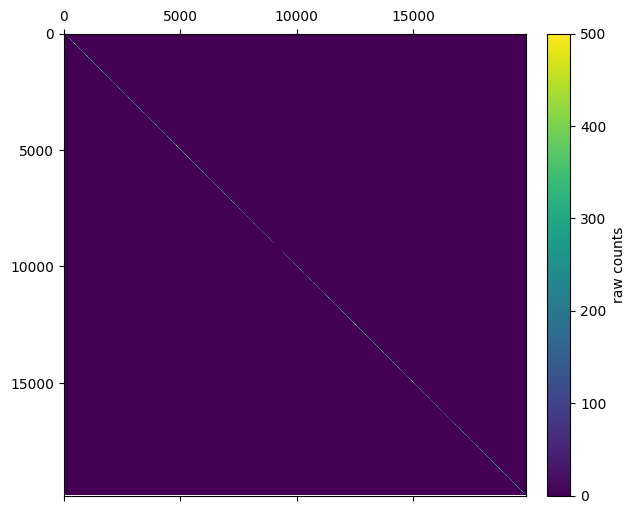

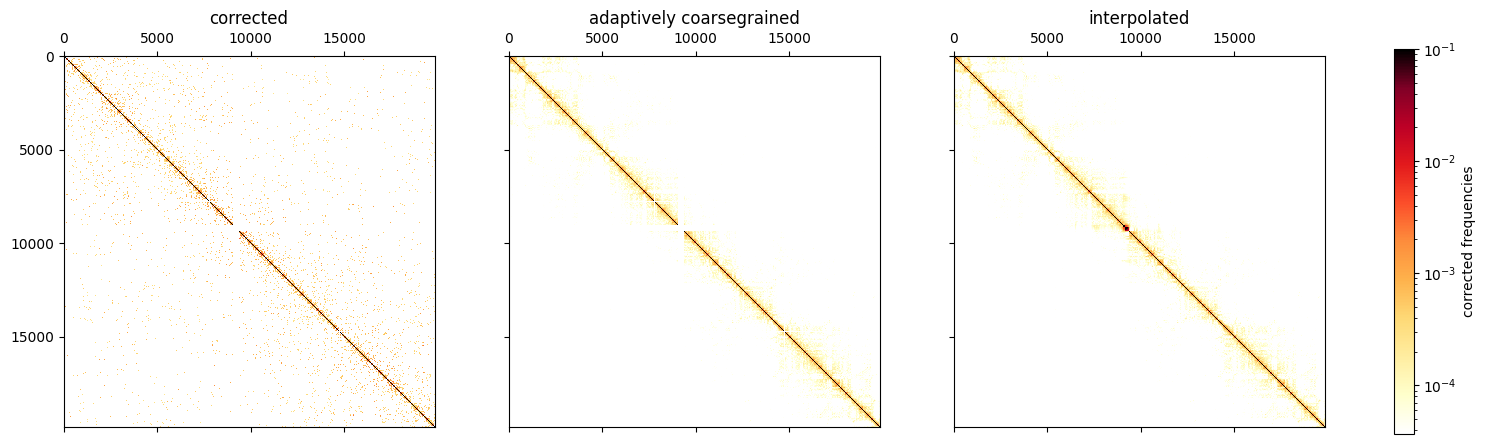

In [6]:
####### visualise M and other matrices ########
M = c.matrix(balance=False).fetch('chr3')[:] #sparse adj matrix
print(M)

#smoothing of matrix using adaptive coarsegraining (based on raw counts) and interpolation (only for vis)
cg = adaptive_coarsegrain(c.matrix(balance=True).fetch('chr3'),
                              c.matrix(balance=False).fetch('chr3'),
                              cutoff=3, max_levels=8)
print(cg)
cgi = interp_nan(cg)
print(cgi)

#make a chromstarts list (utility)
chromstarts = []
for i in c.chromnames:
    print(f'{i} : {c.extent(i)}')
    chromstarts.append(c.extent(i)[0])

#vis matrices
f, ax = plt.subplots(
    figsize=(7,6))
im = ax.matshow(M,vmax=500); plt.colorbar(im ,fraction=0.046, pad=0.04, label='raw counts')
#ax.set(xticks=chromstarts, xticklabels=c.chromnames,
       #xlabel='position, chrom#', ylabel='position, bin#')
ax.xaxis.set_label_position('top')

#vis smoothed matrices
norm = LogNorm(vmax=0.1)
f, axs = plt.subplots(
    figsize=(18,5),
    nrows=1,
    ncols=3,
    sharex=True, sharey=True)

ax = axs[0]
im = ax.matshow(c.matrix(balance=True).fetch('chr3'), cmap='fall', norm=norm)
ax.set_title('corrected')

ax = axs[1]
im2 = ax.matshow(cg, cmap='fall', norm=norm)
ax.set_title(f'adaptively coarsegrained')

ax = axs[2]
im3 = ax.matshow(cgi, cmap='fall', norm=norm)
ax.set_title(f'interpolated')

plt.colorbar(im3, ax=axs, fraction=0.046, label='corrected frequencies')

In [7]:
######### O/E edge calculation #########
'''
The O/E matrix is calculated as the log2 ratio of the raw contact matrix to the expected contact matrix.
The expected contact matrix is calculated by filling in the average value of the diagonals of the raw contact matrix.
'''
def sqrt_norm(matrix):
	coverage = (np.sqrt(np.sum(matrix, axis=-1)))
	with np.errstate(divide='ignore', invalid='ignore'):
		matrix = matrix / coverage.reshape((-1, 1)); matrix = matrix / coverage.reshape((1, -1))
	matrix[np.isnan(matrix)] = 0.0; matrix[np.isinf(matrix)] = 0.0
	return matrix

#scGHOST's way of getting o/e
def get_oe_logtrans(M,eps=1e-5,threshold=10):
    #construct expected matrix
    E = np.zeros_like(M).astype(float)
    l = len(M)
    sums = []
    for i in range(M.shape[0]):
        contacts = np.diag(M,i)
        expected = contacts.sum() / (l-i) #chr wide expected, not factorized by number of chrs for genome-wide comparison
        sums.append(expected)
        #uniform distribution of contacts across diagonals assumed
        x_diag,y_diag = np.diag_indices(M.shape[0]-i)
        x,y = x_diag,y_diag+i
        E[x,y] = expected
    E += E.T
    E = np.nan_to_num(E) + eps
    OE = M / E 
    OE[OE == 0] = 1 #to avoid neg inf in log
    OE = np.log(OE) #log transform the OE to get equal-sized bins, as the expected values need to be log binned
	# threshold elements based on M (decide on an adaptive threshold)
    OE_filtered = np.where(OE > 0.1, OE, 0)
    return OE , OE_filtered, E, sums

def pearson(matrix):
	return np.corrcoef(matrix)

o_e_log, OE_thresholded, expected, sums = get_oe_logtrans(cgi[:]) #o/e of raw contact matrix

#print the number of non-zero elements in the O/E matrix
print(np.count_nonzero(o_e_log))
print(np.count_nonzero(OE_thresholded))
print(sums) #check for nans in E


393228900
34332121
[0.09775388424252471, 0.055189852345045254, 0.02493662163934584, 0.017048437388260815, 0.013304366332124527, 0.011064952744956613, 0.009638972412368756, 0.00860996626147076, 0.007838476196327776, 0.007202721363121684, 0.006720285954989702, 0.0063184420035922555, 0.0059628255373887626, 0.005668320209449819, 0.005392575481790831, 0.0051644489028168815, 0.004950674650505529, 0.004751125893006024, 0.00457301826391637, 0.004417863077146541, 0.004251798669992578, 0.004128905410881365, 0.003988371268666137, 0.0038648872331822296, 0.0037481238822307393, 0.0036313320724041193, 0.0035223590644490907, 0.0034311821510026124, 0.0033450032208826833, 0.0032550788339079555, 0.003165312046873504, 0.003086051693340945, 0.003007863367379087, 0.0029346101694983076, 0.0028619165615549253, 0.0027966880424312507, 0.0027197602514353035, 0.0026594782743206563, 0.002588489570263564, 0.002534445502635208, 0.002480976159773688, 0.0024300440836932755, 0.0023722916149065514, 0.00231891290842794, 

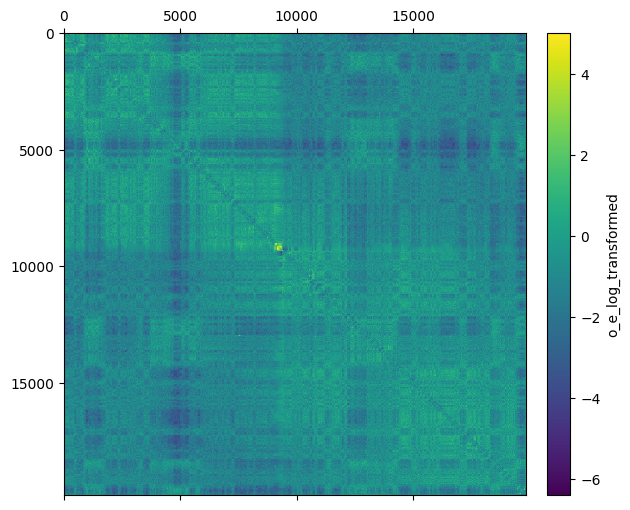

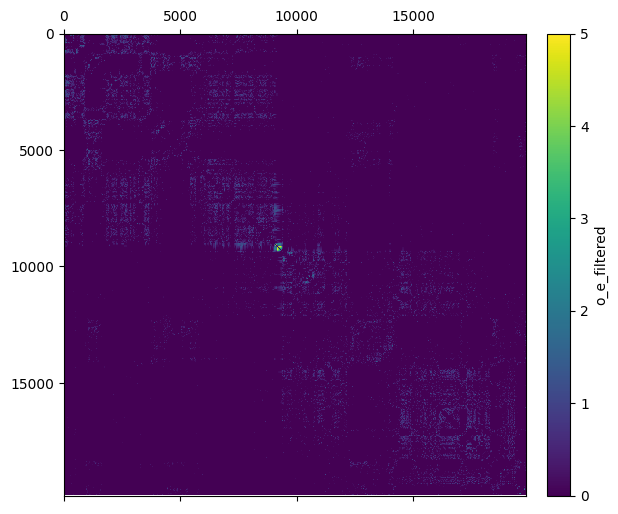

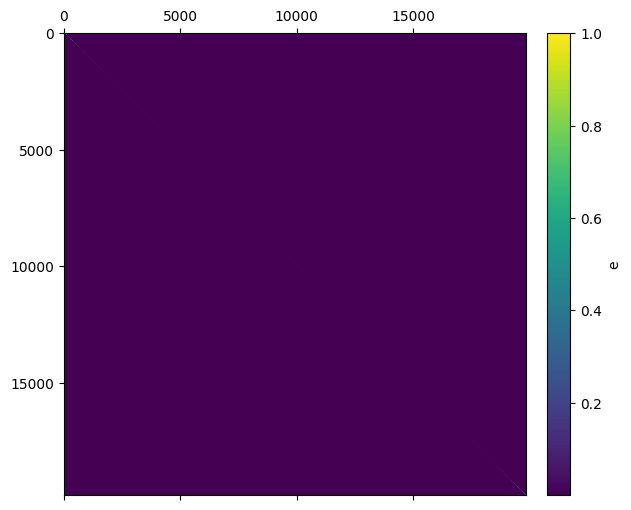

In [8]:
######### visualise matrices ########

f, ax = plt.subplots(
   figsize=(7,6))
im = ax.matshow(o_e_log,vmax=5); plt.colorbar(im ,fraction=0.046, pad=0.04, label='o_e_log_transformed')
#ax.set(xticks=chromstarts, xticklabels=c.chromnames,
       #xlabel='position, chrom#', ylabel='position, bin#')
ax.xaxis.set_label_position('top')

#plot another oe matrix
f, ax = plt.subplots(
   figsize=(7,6))
im = ax.matshow(OE_thresholded,vmax=5); plt.colorbar(im ,fraction=0.046, pad=0.04, label='o_e_filtered')
ax.xaxis.set_label_position('top')

#plot E matrix too
f, ax = plt.subplots(
   figsize=(7,6))
im = ax.matshow(expected,vmax=1); plt.colorbar(im ,fraction=0.046, pad=0.04, label='e')
ax.xaxis.set_label_position('top')

A/B compartments

In [11]:
###### calc A/B scores to validate the contact maps at 250Kb ########
'''
Higashi: Raw -> normalised -> O/E -> Pearson -> PCA gives A/B 
'''
def get_A_B(matrix):
    #ensure diagonals are 1
    np.fill_diagonal(matrix, 1)
    #get pearson matrix
    matrix = np.corrcoef(matrix)
    np.fill_diagonal(matrix, 1)
    matrix[np.isnan(matrix)] = 0.0
    pca = PCA(n_components=1)
    y = pca.fit_transform(matrix)
    return y, pca

## save e1 as a bigwig track for one chr ##
def e1_bigwig(bins, e1_values, chromsizes, output_file='e1.bw'):
    e1_values = e1_values.flatten()
    chroms = bins['chrom'].values
    chroms = np.array([chroms[i].encode() for i in range(len(chroms))])
    starts = bins['start'].values.astype(int)
    ends = bins['end'].values.astype(int)
    #adding chromsize header to bigwig file
    bw = pyBigWig.open(output_file, "w")
    bw.addHeader(list(chromsizes.items())) #dict of 'chr' and 'size'
    #adding entries (bulk addition as each chroms, starts, ends, values can be numpy arrays)
    bw.addEntries(chroms, starts, ends=ends, values=e1_values)  
    bw.close()
    print(f'BigWig file saved to {output_file}')

# load chromsizes
chromsizes = bioframe.fetch_chromsizes('hg19')
chromsizes = chromsizes.to_dict()
print(chromsizes)

bins = c.bins().fetch('chr3')[:] #select for each chr
e1 = get_A_B(o_e_log)
#print(e1)
e1_bigwig(bins, e1[0], chromsizes, 'e1.bw')

{'chr1': 249250621, 'chr2': 243199373, 'chr3': 198022430, 'chr4': 191154276, 'chr5': 180915260, 'chr6': 171115067, 'chr7': 159138663, 'chr8': 146364022, 'chr9': 141213431, 'chr10': 135534747, 'chr11': 135006516, 'chr12': 133851895, 'chr13': 115169878, 'chr14': 107349540, 'chr15': 102531392, 'chr16': 90354753, 'chr17': 81195210, 'chr18': 78077248, 'chr19': 59128983, 'chr20': 63025520, 'chr21': 48129895, 'chr22': 51304566, 'chrX': 155270560, 'chrY': 59373566, 'chrM': 16571}
BigWig file saved to e1.bw


In [27]:
##### insulation score at 10kb or 5kb #####
# needs <10kb bin size to detect tads using diamond score method and >100M total filtered reads mapped to the genome
def insulation_score(m, windowsize=500000, res=10000):
	windowsize_bin = int(windowsize / res)
	score = np.ones((m.shape[0]))
	for i in range(0, m.shape[0]):
		with np.errstate(divide='ignore', invalid='ignore'):
			v = np.sum(m[max(0, i - windowsize_bin): i, i + 1: min(m.shape[0] - 1, i + windowsize_bin + 1)]) / (np.sum(
				m[max(0, i - windowsize_bin):min(m.shape[0], i + windowsize_bin + 1),
				max(0, i - windowsize_bin):min(m.shape[0], i + windowsize_bin + 1)]))
			if np.isnan(v):
				v = 1.0
		
		score[i] = v
		#get log2 of the score
		#score[score == 0] = 1
		#score = np.log2(score)
	return score

def ins_bigwig(bins, ins_values, chromsizes, output_file='ins.bw'):
    ins_values = ins_values.flatten()
    chroms = bins['chrom'].values
    chroms = np.array([chroms[i].encode() for i in range(len(chroms))])
    starts = bins['start'].values.astype(int)
    ends = bins['end'].values.astype(int)
    #adding chromsize header to bigwig file
    bw = pyBigWig.open(output_file, "w")
    bw.addHeader(list(chromsizes.items())) #dict of 'chr' and 'size'
    #adding entries (bulk addition as each chroms, starts, ends, values can be numpy arrays)
    bw.addEntries(chroms, starts, ends=ends, values=ins_values)  
    bw.close()
    print(f'BigWig file saved to {output_file}')
# load chromsizes
chromsizes = bioframe.fetch_chromsizes('hg19')
chromsizes = chromsizes.to_dict()
print(chromsizes)

bins = c.bins().fetch('chr3')[:] #select for each chr
insulation = insulation_score(cgi[:], windowsize=200000, res=resolution)
print(insulation)
ins_bigwig(bins, insulation, chromsizes, 'ins_200_10kb.bw')

{'chr1': 249250621, 'chr2': 243199373, 'chr3': 198022430, 'chr4': 191154276, 'chr5': 180915260, 'chr6': 171115067, 'chr7': 159138663, 'chr8': 146364022, 'chr9': 141213431, 'chr10': 135534747, 'chr11': 135006516, 'chr12': 133851895, 'chr13': 115169878, 'chr14': 107349540, 'chr15': 102531392, 'chr16': 90354753, 'chr17': 81195210, 'chr18': 78077248, 'chr19': 59128983, 'chr20': 63025520, 'chr21': 48129895, 'chr22': 51304566, 'chrX': 155270560, 'chrY': 59373566, 'chrM': 16571}
[0.         0.01035695 0.02307836 ... 0.01014724 0.         0.        ]
BigWig file saved to ins_200_10kb.bw


In [19]:
##### p-value thresholding #####

In [21]:
####### All edges are loaded ########

#whole genome contact matrix/edges as pandas df (reading as np array and not csr format as sparse=False)
#keeping balanced as true, not using raw counts
pixels = c.matrix(balance=True, sparse=False, as_pixels=True, join=False, divisive_weights=None)[:] #pixels table is read as pd df
#print(pixels.head())
edge_list = pixels[['bin1_id', 'bin2_id', 'balanced']].values #convert to numpy array
#remove self-loops (these are intra-chr, self-interactions)
edge_list = edge_list[edge_list[:,0]!=edge_list[:,1]]
#remove filtered bins (NAN values in balanced edges)
edge_list = edge_list[~np.isnan(edge_list[:,2])]
print(len(edge_list))

3972608


In [22]:
######### Loading only intra-chromosomal edges #########
#for 1Mb, only 223,829 (5.4%) of the total edges (3,972,608) are intra-chr. majority of edges are inter-chr.
#A2 = c.matrix().fetch('chr2', 'chr3') #inter edges; A3 = c.matrix().fetch('chr3:10M-20M', 'chr3:35M-40M') #intra edges

all_edges = c.matrix(balance=True, sparse=False, as_pixels=True, join=False, divisive_weights=None) #not a pd df
chr_edges = []
for i in range(22):
    chr = 'chr' + str(i+1)
    chr_edges.append(all_edges.fetch(chr, chr)[:])
chr_edges.append(all_edges.fetch('chrX', 'chrX')[:])
chr_edges.append(all_edges.fetch('chrY', 'chrY')[:])

#join all list items into one item
chr_edges = np.vstack(chr_edges)
#select column 0,1,3(balanced), 2 is for raw counts
chr_edges = chr_edges[:,[0,1,3]] 
#remove self-loops
chr_edges = chr_edges[chr_edges[:,0]!=chr_edges[:,1]]
#remove filtered bins
chr_edges = chr_edges[~np.isnan(chr_edges[:,2])]

print(len(chr_edges))

207836


In [23]:
###### loading chr-specific edges ########

chr1_edges = c.matrix(balance=True, sparse=False, as_pixels=True, join=False, divisive_weights=None).fetch('chr1', 'chr1')[:]
#convert to numpy array
chr1_edges = chr1_edges[['bin1_id', 'bin2_id', 'balanced']].values
#removing self loops
chr1_edges = chr1_edges[chr1_edges[:,0]!=chr1_edges[:,1]]
#remove filtered bins (Nans) in balanced
chr1_edges = chr1_edges[~np.isnan(chr1_edges[:,2])] 
print(len(chr1_edges))


24753


In [24]:
##### loading OE thresholded as edges #####

non_zero_indices = np.nonzero(OE_thresholded)
oe_edges = list(zip(non_zero_indices[0], non_zero_indices[1]))
print(len(oe_edges))



197735


In [ ]:
Graph clustering to find TADs, other communities (hubs)

In [ ]:
###### Louvain implementation ######

Graph creation

In [6]:
# Create a full graph 
G = nx.Graph()
G.add_weighted_edges_from(edge_list) #if slow use add_edges_from() after making a dictionary of norm_weights

In [ ]:
#create a intra-chr graph
G_chr = nx.Graph()
G_chr.add_weighted_edges_from(chr_edges)


In [17]:
#create a chr-specific graph
G_chr1 = nx.Graph()
G_chr1.add_weighted_edges_from(chr1_edges)

In [13]:
#O/E graph
G_OE_thresholded = nx.Graph()
G_OE_thresholded.add_edges_from(oe_edges)
nx.write_gexf(G_OE_thresholded, "GM12878_"+str(resolution)+"chr1_OE_thresholded.gexf")

In [ ]:
#create a graph with less weight on the inter-chr edges

In [18]:
# Save graph in gexf format for visualisation

#make a graphs folder if doesn't exist
if not os.path.exists('graphs'):
    os.makedirs('graphs')
nx.write_gexf(G_chr1, "graphs/GM12878_1Mb_Chr1.gexf")